<a href="https://colab.research.google.com/github/lauramendescd/sinasc-analise/blob/main/descriptive_analysis_Laura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise Descritiva

In [ ]:
# Verificar a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171699 entries, 0 to 1171698
Data columns (total 66 columns):
 #   Column                             Non-Null Count    Dtype 
---  ------                             --------------    ----- 
 0   ano                                1171699 non-null  Int64 
 1   sigla_uf                           1171699 non-null  object
 2   sequencial_nascimento              1171699 non-null  object
 3   id_municipio_nascimento            1171699 non-null  object
 4   local_nascimento                   1171699 non-null  object
 5   codigo_estabelecimento             1166496 non-null  object
 6   data_nascimento                    1171699 non-null  dbdate
 7   hora_nascimento                    1057445 non-null  dbtime
 8   sexo                               1171699 non-null  object
 9   peso                               1171659 non-null  Int64 
 10  raca_cor                           978145 non-null   object
 11  apgar1                             11

Index(['ano', 'sigla_uf', 'sequencial_nascimento', 'id_municipio_nascimento',
       'local_nascimento', 'codigo_estabelecimento', 'data_nascimento',
       'hora_nascimento', 'sexo', 'peso', 'raca_cor', 'apgar1', 'apgar5',
       'id_anomalia', 'codigo_anomalia', 'semana_gestacao',
       'semana_gestacao_estimada', 'gestacao_agr', 'tipo_gravidez',
       'tipo_parto', 'inicio_pre_natal', 'pre_natal', 'pre_natal_agr',
       'classificacao_pre_natal', 'quantidade_filhos_vivos',
       'quantidade_filhos_mortos', 'id_pais_mae', 'id_uf_mae',
       'id_municipio_mae', 'id_pais_residencia', 'id_municipio_residencia',
       'data_nascimento_mae', 'idade_mae', 'escolaridade_mae',
       'serie_escolar_mae', 'escolaridade_2010_mae',
       'escolaridade_2010_agr_mae', 'estado_civil_mae', 'ocupacao_mae',
       'raca_cor_mae', 'gestacoes_ant', 'quantidade_parto_normal',
       'quantidade_parto_cesareo', 'data_ultima_menstruacao',
       'tipo_apresentacao', 'inducao_parto', 'cesarea_antes_

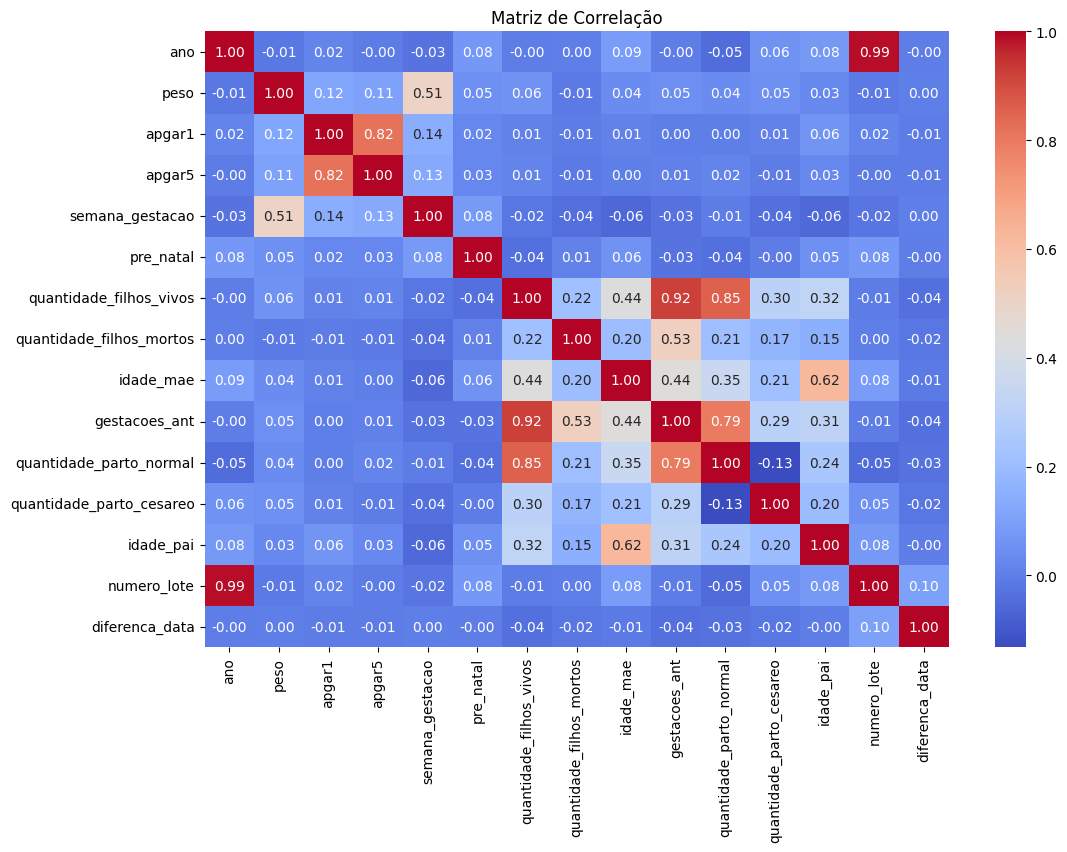

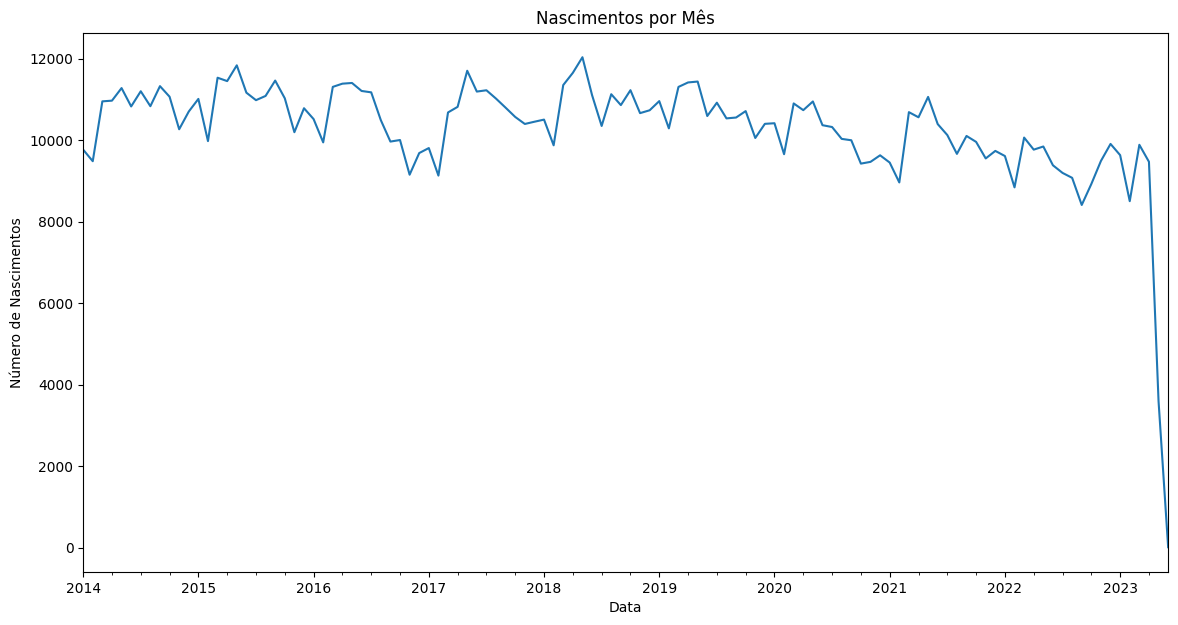

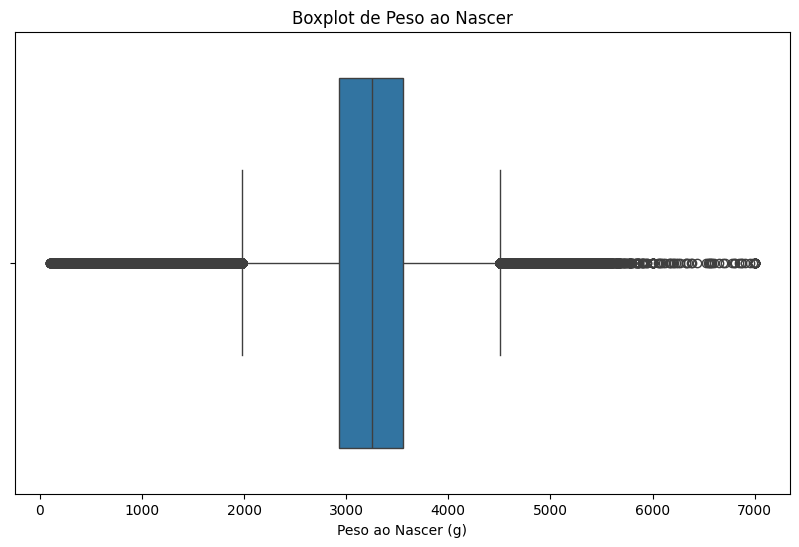

Outliers:
          ano sigla_uf sequencial_nascimento id_municipio_nascimento  \
295      2018       CE                277218                 2304707   
727      2018       CE                300823                 2312908   
1173     2018       CE               1792275                 2304400   
1296     2018       CE               1788478                 2304400   
1337     2018       CE               1804244                 2304400   
...       ...      ...                   ...                     ...   
1171196  2014       CE                101115                 2304400   
1171541  2014       CE                 89141                 2304400   
1171688  2014       CE                 90763                 2304400   
1171694  2014       CE                 34073                 2304400   
1171698  2014       CE                128679                 2304400   

        local_nascimento codigo_estabelecimento data_nascimento  \
295                    1                2333899      2018-

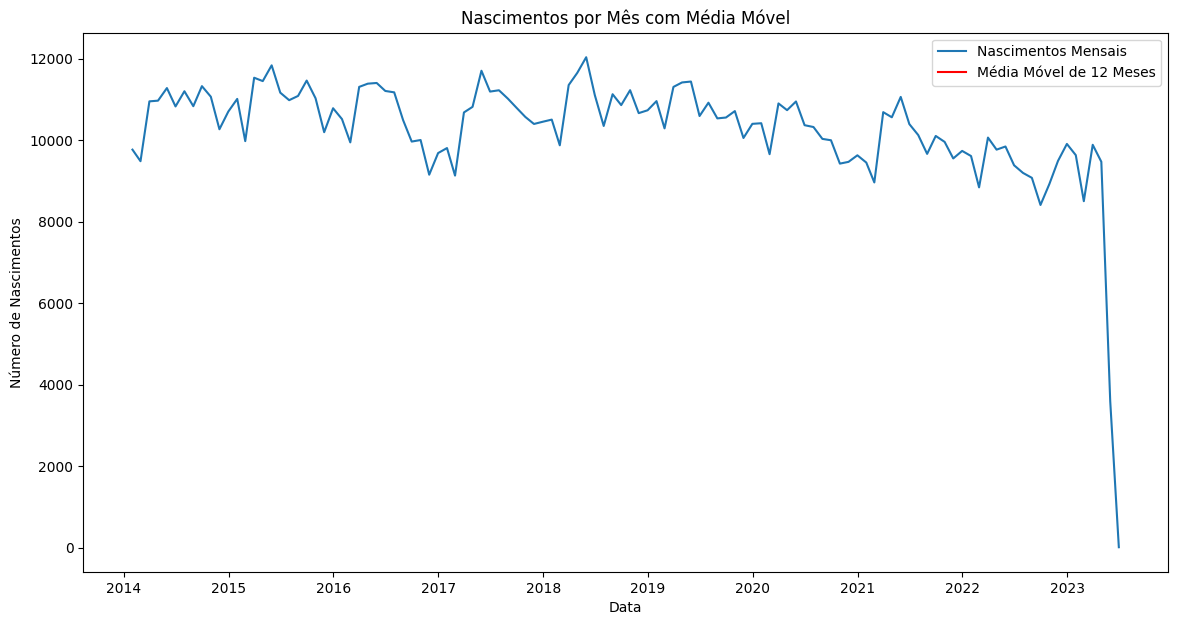

faixa_etaria_mae
10-20    251197
20-30    579309
30-40    318156
40-50     22908
Name: count, dtype: int64


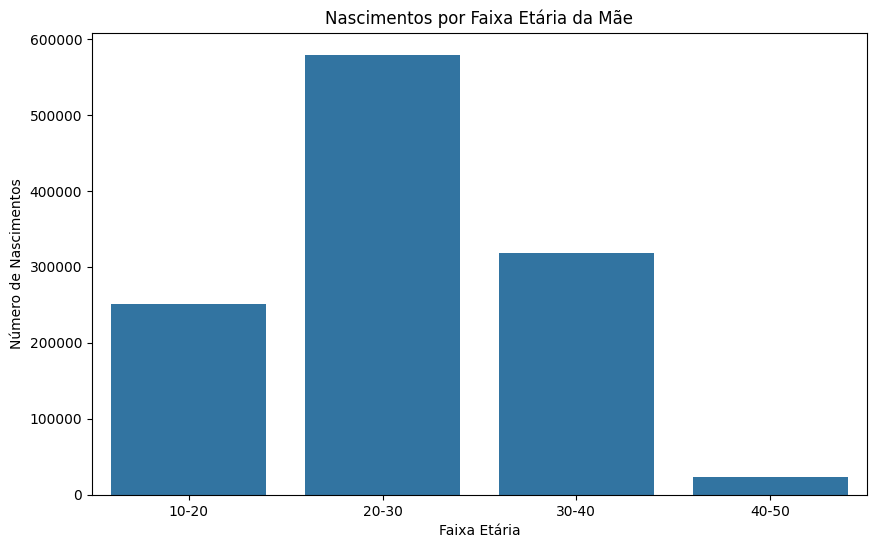

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Definindo o caminho para o arquivo de credenciais no Google Colab
path_to_credentials = '/content/projeto-iii-425700-4b6d9ee58aae.json'

# Definindo a variável de ambiente para as credenciais do Google Cloud
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = path_to_credentials

# Inicializando o cliente do BigQuery
client = bigquery.Client()

# Consulta SQL para selecionar todas as colunas dos dados do SINASC do estado do Ceará a partir de 2014
query = """
SELECT *
FROM `basedosdados.br_ms_sinasc.microdados`
WHERE EXTRACT(YEAR FROM data_nascimento) >= 2014
AND sigla_uf = 'CE'
"""

# Executar a consulta
query_job = client.query(query)

# Obtendo os resultados em um DataFrame do Pandas
df = query_job.to_dataframe()

# Convertendo a coluna de data para datetime
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])

# Verificar a estrutura do DataFrame
print(df.columns)

# Selecionar apenas as colunas numéricas para a matriz de correlação
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Análise de Correlação
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

# Análise de Séries Temporais
nascimentos_por_mes = df.resample('M', on='data_nascimento').size()
plt.figure(figsize=(14, 7))
nascimentos_por_mes.plot()
plt.title('Nascimentos por Mês')
plt.xlabel('Data')
plt.ylabel('Número de Nascimentos')
plt.show()

# Análise de Outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='peso', data=df)
plt.title('Boxplot de Peso ao Nascer')
plt.xlabel('Peso ao Nascer (g)')
plt.show()

Q1 = df['peso'].quantile(0.25)
Q3 = df['peso'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['peso'] < (Q1 - 1.5 * IQR)) | (df['peso'] > (Q3 + 1.5 * IQR))]
print(f"Outliers:\n{outliers}")

# Análise de Tendências
df['nascimentos_rolante'] = nascimentos_por_mes.rolling(window=12).mean()
plt.figure(figsize=(14, 7))
plt.plot(nascimentos_por_mes, label='Nascimentos Mensais')
plt.plot(df['nascimentos_rolante'], label='Média Móvel de 12 Meses', color='red')
plt.title('Nascimentos por Mês com Média Móvel')
plt.xlabel('Data')
plt.ylabel('Número de Nascimentos')
plt.legend()
plt.show()

# Análise de Subgrupos
df['faixa_etaria_mae'] = pd.cut(df['idade_mae'], bins=[10, 20, 30, 40, 50], labels=['10-20', '20-30', '30-40', '40-50'])
nascimentos_por_faixa_etaria = df['faixa_etaria_mae'].value_counts().sort_index()
print(nascimentos_por_faixa_etaria)

plt.figure(figsize=(10, 6))
sns.countplot(x='faixa_etaria_mae', data=df)
plt.title('Nascimentos por Faixa Etária da Mãe')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Nascimentos')
plt.show()


+----+-----------------------------------+----------------------------+----------------------------------+
|    |              Coluna               | Total de Valores Faltantes | Porcentagem de Valores Faltantes |
+----+-----------------------------------+----------------------------+----------------------------------+
| 0  |             cartorio              |          1171699           |              100.0               |
| 1  |         registro_cartorio         |          1171699           |              100.0               |
| 2  |      data_registro_cartorio       |          1171699           |              100.0               |
| 3  |          codigo_anomalia          |          1160734           |        99.06417945223134         |
| 4  |             idade_pai             |          1003072           |        85.60833456374036         |
| 5  |     data_recebimento_original     |           891835           |        76.11468474411943         |
| 6  |         serie_escolar_mae     

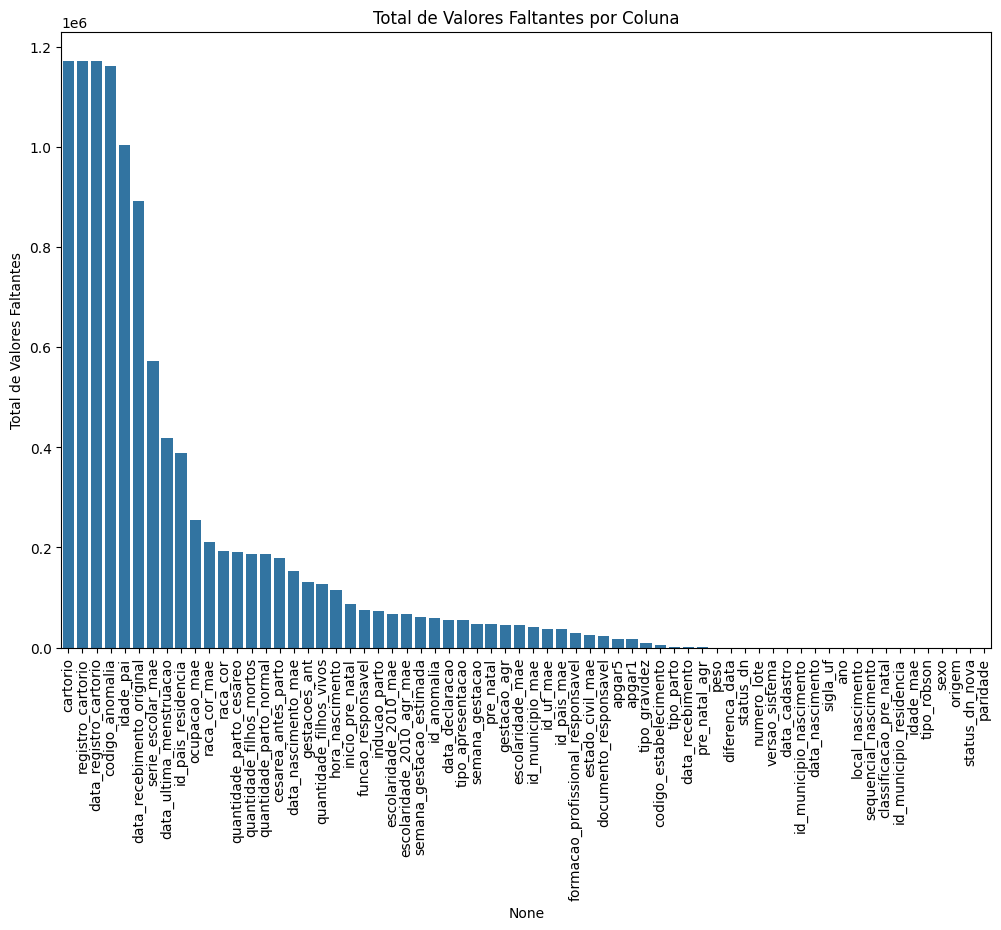

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import missingno as msno
from tabulate import tabulate

# Configuração para exibir todas as colunas
pd.set_option('display.max_rows', None)

# Definindo o caminho para o arquivo de credenciais no Google Colab
path_to_credentials = '/content/projeto-iii-425700-4b6d9ee58aae.json'

# Definindo a variável de ambiente para as credenciais do Google Cloud
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = path_to_credentials

# Inicializando o cliente do BigQuery
client = bigquery.Client()

# Consulta SQL para selecionar todas as colunas dos dados do SINASC do estado do Ceará a partir de 2014
query = """
SELECT *
FROM `basedosdados.br_ms_sinasc.microdados`
WHERE EXTRACT(YEAR FROM data_nascimento) >= 2014
AND sigla_uf = 'CE'
"""

# Executar a consulta
query_job = client.query(query)

# Obtendo os resultados em um DataFrame do Pandas
df = query_job.to_dataframe()

# Convertendo a coluna de data para datetime
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])

# Visualizar o total de valores faltantes por coluna
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# Criar um DataFrame para os valores faltantes
missing_data = pd.DataFrame({
    'Coluna': missing_values.index,
    'Total de Valores Faltantes': missing_values.values,
    'Porcentagem de Valores Faltantes': missing_percentage.values
})

# Exibir a tabela formatada usando tabulate
print(tabulate(missing_data, headers='keys', tablefmt='pretty'))

# Visualizar as colunas com valores faltantes em um gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.title('Total de Valores Faltantes por Coluna')
plt.xticks(rotation=90)
plt.ylabel('Total de Valores Faltantes')
plt.show()


